In [1]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

In [2]:
df_train = pd.read_csv('train_processed_isolation_forest.csv')
df_train.head(10)


,employee_id,date,employee_seniority_years,num_print_commands,total_printed_pages,num_print_commands_off_hours,num_printed_pages_off_hours,num_color_prints,num_bw_prints,ratio_color_prints,...,month_freq_quartile,is_end_of_month_binary_zscore,is_quarter_end_binary_zscore,high_classification_burn_binary_zscore,is_heavy_burner_binary_zscore,is_heavy_printer_binary_zscore,is_employee_in_origin_country_binary_zscore,is_new_employee_binary_zscore,is_veteran_employee_binary_zscore,is_malicious
0,849,2025-05-14,0.820369,-0.603326,-0.325535,-0.188799,-0.079475,-0.2373,-0.350274,-0.558013,...,1.685542,-0.508422,-0.715710,-0.071885,-0.472213,-0.445172,-0.013748,-0.135203,0.834751,1
1,1370,2025-06-07,-0.937306,1.211276,0.275436,-0.188799,-0.079475,-0.2373,0.420338,0.923207,...,-0.182319,-0.508422,1.397213,-0.071885,-0.472213,-0.445172,-0.013748,-0.135203,-1.197962,0
2,726,2025-04-09,-0.126071,0.848355,0.275436,-0.188799,-0.079475,-0.2373,0.420338,0.389968,...,-0.182319,-0.508422,-0.715710,-0.071885,-0.472213,-0.445172,-0.013748,-0.135203,0.834751,0
3,711,2025-04-03,0.955575,-0.603326,-0.325535,-0.188799,-0.079475,-0.2373,-0.350274,-0.558013,...,-0.182319,-0.508422,-0.715710,-0.071885,-0.472213,-0.445172,-0.013748,-0.135203,0.834751,0
4,779,2025-03-14,0.820369,-0.603326,-0.325535,-0.188799,-0.079475,-0.2373,-0.350274,-0.558013,...,0.751611,-0.508422,1.397213,-0.071885,-0.472213,-0.445172,-0.013748,-0.135203,0.834751,0
5,70,2025-04-07,-1.207717,0.122514,-0.133224,-0.188799,-0.079475,-0.2373,-0.196152,0.219656,...,-0.182319,-0.508422,-0.715710,-0.071885,-0.472213,-0.445172,-0.013748,-0.135203,-1.197962,0
6,313,2025-06-15,0.820369,-0.603326,-0.325535,-0.188799,-0.079475,-0.2373,-0.350274,-0.558013,...,-0.182319,-0.508422,1.397213,-0.071885,-0.472213,-0.445172,-0.013748,-0.135203,0.834751,0
7,481,2025-04-07,-0.126071,-0.603326,-0.325535,-0.188799,-0.079475,-0.2373,-0.350274,-0.558013,...,-0.182319,-0.508422,-0.715710,-0.071885,-0.472213,-0.445172,-0.013748,-0.135203,0.834751,0
8,760,2025-01-31,2.037221,-0.603326,-0.325535,-0.188799,-0.079475,-0.2373,-0.350274,-0.558013,...,-1.116249,-0.508422,-0.715710,-0.071885,-0.472213,-0.445172,-0.013748,-0.135203,0.834751,0
9,1494,2025-05-18,0.955575,-0.603326,-0.325535,-0.188799,-0.079475,-0.2373,-0.350274,-0.558013,...,1.685542,-0.508422,-0.715710,-0.071885,-0.472213,-0.445172,-0.013748,-0.135203,0.834751,0


In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179928 entries, 0 to 179927
Columns: 130 entries, employee_id to is_malicious
dtypes: float64(125), int64(2), object(3)
memory usage: 178.5+ MB


In [25]:
non_numeric_cols = df_train.select_dtypes(exclude=['number']).columns
print(non_numeric_cols)


Index(['date', 'first_entry_time', 'last_exit_time'], dtype='object')


In [5]:
df_train.drop(['date', 'first_entry_time', 'last_exit_time'], axis=1, inplace=True)


KeyError: "['date', 'first_entry_time', 'last_exit_time'] not found in axis"

In [27]:
for col in non_numeric_cols:
    print(f"\nColumn: {col}")
    print(df_train[[col]].head(2))


Column: date


KeyError: "None of [Index(['date'], dtype='object')] are in the [columns]"

In [ ]:
# אימון Isolation Forest
model = IsolationForest(n_estimators=200, contamination=0.05, random_state=42, n_jobs=-1)
model.fit(df_train)


,n_estimators,200
,max_samples,'auto'
,contamination,0.05
,max_features,1.0
,bootstrap,False
,n_jobs,-1
,random_state,42
,verbose,0
,warm_start,False


# Start Isolation forest

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [2]:

# ------------------------
# 1. Load datasets
# ------------------------
df_train = pd.read_csv('train_processed_isolation_forest.csv')
df_test  = pd.read_csv('test_processed_isolation_forest.csv')
df_eval  = pd.read_csv('val_processed_isolation_forest.csv')


In [3]:

# הורדת עמודות לא רלוונטיות אם קיימות
drop_cols = ['date', 'first_entry_time', 'last_exit_time']
for col in drop_cols:
    for df in [df_train, df_test, df_eval]:
        if col in df.columns:
            df.drop(col, axis=1, inplace=True)


In [4]:
df_train.columns[120:]


Index([], dtype='object')

In [33]:
# נסיר פיצרים שקשורים לשייכות העובד למחלקה וכן מאפיינים סטטיים, היות ובמודל הנוכחי אנחנו מעוניינים ללמוד חריגות בהתנהגות העובד כלפי עצמו לאורך זמן
exclude_keywords = [
    'employee_department',
    'employee_position',
    'employee_classification_freq',
    'employee_campus_cat',
    'has_criminal_record',
    'has_medical_history',
    'has_foreign_citizenship',
    'is_contractor',
    'is_employee_in_origin_country',
    'employee_seniority',
    'is_new_employee',
    'is_veteran_employee'
    ]

# הגדרת שמות הפיצרים הרלוונטיים למודל
include_also = [
    'print_vs_department_avg',
    'print_per_minute',
    'prints_percentile',
    'burns_percentile',
    'total_printed_pages_zscore_global',
    'num_print_commands_zscore_global',
    'total_burn_volume_mb_zscore_global'
]

# בניית רשימת הפיצ'רים - כולל גם פרמטרים מהמחסנית השניה
feature_cols = [
    col for col in df.columns
    if (
        (col.endswith('_zscore') or 
         col.endswith('_percentile') or 
         col.endswith('_per_minute') or 
         col.endswith('_vs_department_avg') or
         col.endswith('_quartile') or
         col.endswith('_freq_quartile')) and
        not any(key in col for key in exclude_keywords)
     ) or (col in include_also and col in df.columns)
]

print(len(feature_cols))

df_train = df_train[feature_cols]
df_test  = df_test[feature_cols]
df_eval  = df_eval[feature_cols]

49


KeyError: "['total_presence_minutes_quartile', 'entry_time_numeric_quartile', 'exit_time_numeric_quartile'] not in index"

# new cells 

In [31]:
def add_features(df):
    # בדיקה אם העמודות קיימות
    required_cols = ['total_printed_pages', 'num_print_commands', 'total_burn_volume_mb', 
                     'employee_department_freq', 'total_presence_minutes']
    
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        print(f"Missing columns: {missing_cols}")
        return df
    
    # Z-scores גלובליים
    for col in ['total_printed_pages', 'num_print_commands', 'total_burn_volume_mb']:
        df[f'{col}_zscore_global'] = (df[col] - df[col].mean()) / df[col].std()
    
    # אחוזונים
    df['prints_percentile'] = df['total_printed_pages'].rank(pct=True)
    df['burns_percentile'] = df['total_burn_volume_mb'].rank(pct=True)
    
    # יחס למחלקה
    df['department_avg_print'] = df.groupby('employee_department_freq')['total_printed_pages'].transform('mean')
    df['print_vs_department_avg'] = df['total_printed_pages'] / df['department_avg_print']
    
    # יחס לנוכחות
    df['print_per_minute'] = df['total_printed_pages'] / df['total_presence_minutes']
    
    return df

In [32]:
df_train = add_features(df_train[feature_cols])
df_test  = add_features(df_test[feature_cols])
df_eval  = add_features(df_eval[feature_cols])

KeyError: "['total_presence_minutes_quartile', 'entry_time_numeric_quartile', 'exit_time_numeric_quartile'] not in index"

In [6]:
######## עובד כלפי עצמו
# presence_days = df_train.groupby('employee_id').size().reset_index(name='num_days_present')

# # מחבר את זה חזרה לדאטה המקורית
# df_train = df_train.merge(presence_days, on='employee_id', how='left')
# df_train.head(6)['num_days_present']

# df_train['prints_per_day'] = df_train['total_printed_pages'] / df_train['num_days_present']
# df_train['prints_per_day'].fillna(0, inplace=True)

# df_train['print_off_hours_ratio'] = df_train['num_print_commands_off_hours'] / df_train['num_print_commands']
# df_train['print_off_hours_ratio'].fillna(0, inplace=True)

# df_train['work_hours_deviation'] = df_train['total_presence_minutes'] - 480


In [7]:

# ------------------------
# 2. Train Isolation Forest
# ------------------------
model = IsolationForest(
    n_estimators=300,
    contamination=0.05,     # שיעור הדגימות החריגות שאתה מצפה
    max_samples='auto',     # דגימה אוטומטית מהדאטה
    random_state=42,
    n_jobs=-1,
    verbose=1
)

model.fit(df_train)



[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 out of  24 | elapsed:    0.8s remaining:    9.0s
[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    1.9s finished


,n_estimators,300
,max_samples,'auto'
,contamination,0.05
,max_features,1.0
,bootstrap,False
,n_jobs,-1
,random_state,42
,verbose,1
,warm_start,False


In [8]:
# ------------------------
# 3. Predict on all sets
# ------------------------
def apply_model(df, name="Set"):
    scores = model.decision_function(df)
    preds = model.predict(df)  # -1 = anomaly, 1 = normal

    df_out = df.copy()
    df_out['anomaly_score'] = scores
    df_out['prediction'] = preds

    print(f"\n📊 Summary for {name}:")
    print(df_out['prediction'].value_counts())
    return df_out

df_train_pred = apply_model(df_train, "TRAIN")
df_test_pred  = apply_model(df_test, "TEST")
df_eval_pred  = apply_model(df_eval, "EVAL")


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s



📊 Summary for TRAIN:
prediction
 1    170931
-1      8997
Name: count, dtype: int64


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.5s finished



📊 Summary for TEST:
prediction
 1    57019
-1     2957
Name: count, dtype: int64


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s



📊 Summary for EVAL:
prediction
 1    56911
-1     3065
Name: count, dtype: int64


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.6s finished


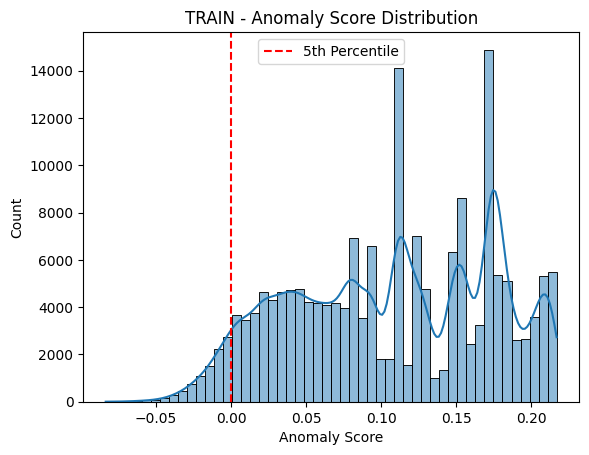

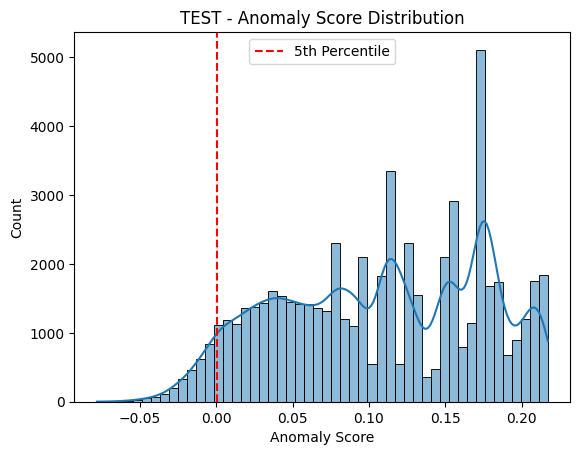

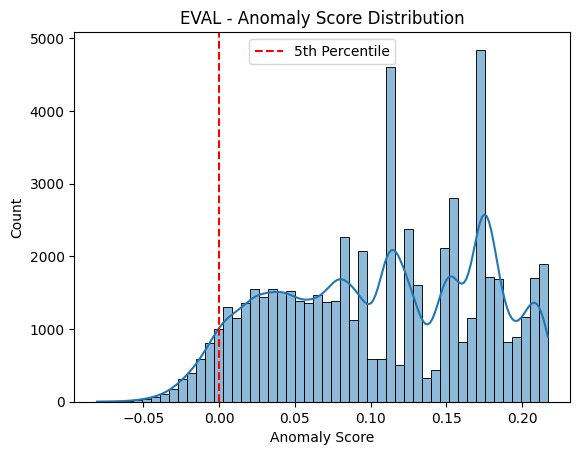

In [9]:

# ------------------------
# 4. Visual Analysis
# ------------------------
def plot_anomaly_distribution(df_pred, title):
    sns.histplot(df_pred['anomaly_score'], bins=50, kde=True)
    plt.title(f"{title} - Anomaly Score Distribution")
    plt.xlabel("Anomaly Score")
    plt.ylabel("Count")
    plt.axvline(x=np.percentile(df_pred['anomaly_score'], 5), color='red', linestyle='--', label='5th Percentile')
    plt.legend()
    plt.show()

plot_anomaly_distribution(df_train_pred, "TRAIN")
plot_anomaly_distribution(df_test_pred, "TEST")
plot_anomaly_distribution(df_eval_pred, "EVAL")



In [10]:
# ------------------------
# 5. Optional: Analyze top anomalies
# ------------------------
def get_top_anomalies(df_pred, top_n=10):
    return df_pred.sort_values(by='anomaly_score').head(top_n)

top_anomalies_train = get_top_anomalies(df_train_pred)
top_anomalies_test  = get_top_anomalies(df_test_pred)

print("\n🕵️‍♂️ Top anomalies in TRAIN:")
print(top_anomalies_train)

print("\n🕵️‍♂️ Top anomalies in TEST:")
print(top_anomalies_test)



🕵️‍♂️ Top anomalies in TRAIN:
        num_print_commands_zscore  total_printed_pages_zscore  \
106864                   1.668607                    0.363086   
163895                   0.524729                    0.334188   
54863                    0.143436                   -0.012589   
61124                    0.524729                    0.363086   
168410                  -0.237856                    0.045207   
47309                    0.906021                    0.363086   
41928                    2.049899                    0.363086   
88186                    0.143436                    0.334188   
2755                    -0.237856                   -0.070385   
152436                   0.143436                   -0.012589   

        num_printed_pages_off_hours_zscore  num_color_prints_zscore  \
106864                           -0.085613                -0.260469   
163895                           -0.085613                -0.260469   
54863                            -0.0856

In [11]:
df_train_pred['prediction'].value_counts()


prediction
 1    170931
-1      8997
Name: count, dtype: int64

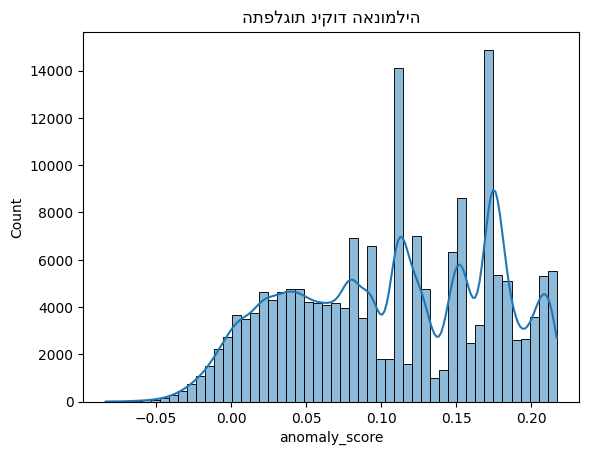

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df_train_pred['anomaly_score'], bins=50, kde=True)
plt.title("התפלגות ניקוד האנומליה")
plt.show()


# EVALUATE MODEL

In [13]:
# 1. Train the model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

model = IsolationForest(n_estimators=200, contamination=0.05, random_state=42)
model.fit(df_train)

# 2. Predict
def apply_model(df):
    df_out = df.copy()
    df_out['anomaly_score'] = model.decision_function(df)
    df_out['prediction'] = model.predict(df)
    return df_out

df_train_pred = apply_model(df_train)
df_test_pred = apply_model(df_test)
df_eval_pred = apply_model(df_eval)

# קריאת הקבצים המקוריים עם העמודה is_malicious
df_train_original = pd.read_csv('train_processed_isolation_forest.csv')
df_test_original = pd.read_csv('test_processed_isolation_forest.csv')
df_eval_original = pd.read_csv('val_processed_isolation_forest.csv')

# הוספת העמודה is_malicious לכל DataFrame לפני הקריאה לפונקציית evaluate_set
df_train_pred['is_malicious'] = df_train_original['is_malicious']
df_test_pred['is_malicious'] = df_test_original['is_malicious']
df_eval_pred['is_malicious'] = df_eval_original['is_malicious']

# 3. Evaluate
def evaluate_set(df, name="SET"):
    y_true = df['is_malicious']
    y_pred = df['prediction'].replace({1: 0, -1: 1})
    print(f"\n📊 Evaluation for {name}:")
    print(classification_report(y_true, y_pred, digits=4))
    print("✅ Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("🎯 Accuracy:", accuracy_score(y_true, y_pred))
    print("🎯 Precision:", precision_score(y_true, y_pred))
    print("🎯 Recall:", recall_score(y_true, y_pred))
    print("🎯 ROC AUC:", roc_auc_score(y_true, y_pred))

evaluate_set(df_train_pred, "TRAIN")
evaluate_set(df_test_pred, "TEST")
evaluate_set(df_eval_pred, "EVAL")



📊 Evaluation for TRAIN:
              precision    recall  f1-score   support

           0     0.9770    0.9520    0.9643    175415
           1     0.0642    0.1281    0.0856      4513

    accuracy                         0.9313    179928
   macro avg     0.5206    0.5400    0.5249    179928
weighted avg     0.9541    0.9313    0.9423    179928

✅ Confusion Matrix:
[[166996   8419]
 [  3935    578]]
🎯 Accuracy: 0.9313392023476057
🎯 Precision: 0.06424363676781149
🎯 Recall: 0.128074451584312
🎯 ROC AUC: 0.5400398481448625

📊 Evaluation for TEST:
              precision    recall  f1-score   support

           0     0.9768    0.9526    0.9645     58472
           1     0.0606    0.1190    0.0803      1504

    accuracy                         0.9317     59976
   macro avg     0.5187    0.5358    0.5224     59976
weighted avg     0.9538    0.9317    0.9423     59976

✅ Confusion Matrix:
[[55699  2773]
 [ 1325   179]]
🎯 Accuracy: 0.931672669067627
🎯 Precision: 0.06063685636856368
🎯 Reca

In [ ]:
df.head(5)['num_days_present']

KeyError: 'num_days_present'

In [ ]:

df = df_train
df['prints_per_day'] = df['total_printed_pages'] / df['num_days_present']
df['prints_per_day'].fillna(0, inplace=True)

df['print_off_hours_ratio'] = df['num_print_commands_off_hours'] / df['num_print_commands']
df['print_off_hours_ratio'].fillna(0, inplace=True)

df['work_hours_deviation'] = df['total_presence_minutes'] - 480


/tmp/ipykernel_6449/3262458546.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['prints_per_day'].fillna(0, inplace=True)
/tmp/ipykernel_6449/3262458546.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usi